# ArC (Argument-based Consistency) Metrics Demo

This notebook demonstrates how to use the ArC framework to compute and analyze toxicity explanation metrics for LLMs.

## Overview

ArC evaluates LLM reasoning about toxicity through six metrics across five dimensions:

1. **Non-Redundant Relevance:** SoS (Strength of Support), DiS-Avg (Diversity in Support)
2. **Internal Reliance:** UII (Unused Internal Information)
3. **External Reliance:** UEI (Unused External Information)
4. **Individual Sufficiency:** RS (Reason Sufficiency)
5. **Individual Necessity:** RN (Reason Necessity)

In [1]:
# Import required libraries
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Import ArC components
from core.models.arc_config import ArCConfig
from services.arc_service import ArCService
from utils import helpers as hp

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

c:\Users\RDR\.conda\envs\haf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Configuration Setup

First, let's create an ArC configuration with default parameters.

In [2]:
# Create ArC configuration with default parameters
config = ArCConfig.from_args(
    explicit_prompting=True,  # Use explicit reasoning instructions
    use_scores=False,         # Use logits-based entropy (not scores)
    similarity_model='cross-encoder/stsb-distilroberta-base'
)

print(f"Configuration:")
print(f"  Explicit Prompting: {config.explicit_prompting}")
print(f"  Entropy Mode: {config.entropy_mode}")
print(f"  Similarity Model: {config.similarity_model}")

Configuration:
  Explicit Prompting: _explicit
  Entropy Mode: logits
  Similarity Model: cross-encoder/stsb-distilroberta-base


## 2. Initialize ArC Service

The ArCService handles all metric computations.

In [3]:
# Initialize the ArC service
service = ArCService(config)

print(f"Available models: {service.model_names}")
print(f"Available datasets: {service.data_names}")

Available models: ['meta-llama/Llama-3.2-3B-Instruct', 'meta-llama/Llama-3.1-8B-Instruct', 'mistralai/Ministral-8B-Instruct-2410', 'meta-llama/Llama-3.3-70B-Instruct']
Available datasets: ['civil_comments', 'hate_explain', 'real_toxicity_prompts', 'implicit_toxicity', 'toxigen']


## 3. Load Pre-computed Results

Let's load and examine pre-computed ArC results for a specific model and dataset.

In [4]:
# Specify model and dataset
model_name = "Llama-3.1-8B-Instruct"
data_name = "civil_comments"

# Load results
results_path = Path("arc_results") / model_name / data_name

if results_path.exists():
    # Load all result files
    results = []
    for pkl_file in sorted(results_path.glob("*.pkl")):
        with open(pkl_file, 'rb') as f:
            sample_result = pickle.load(f)
            sample_result['sample_idx'] = int(pkl_file.stem)
            results.append(sample_result)
    
    print(f"Loaded {len(results)} samples for {model_name} on {data_name}")
else:
    print(f"Results not found at {results_path}")
    print("Please run: python arc.py")
    results = []

Loaded 8 samples for Llama-3.1-8B-Instruct on civil_comments


## 4. Examine a Single Sample

Let's look at the detailed metrics for one sample.

In [5]:
if results:
    # Get first sample
    sample = results[0]
    
    print("=" * 80)
    print(f"Sample {sample['sample_idx']} Metrics")
    print("=" * 80)
    
    # Initial reasons
    print(f"\nInitial Reasons ({len(sample.get('initial_reasons', []))})")
    for i, reason in enumerate(sample.get('initial_reasons', [])):
        print(f"  {i+1}. {reason[:100]}...")
    
    # Decision confidences
    print(f"\nDecision Confidences:")
    print(f"  Initial: {sample.get('initial_decision_confidence', 'N/A'):.4f}")
    print(f"  Internal: {sample.get('internal_decision_confidence', 'N/A'):.4f}")
    print(f"  External: {sample.get('external_decision_confidence', 'N/A'):.4f}")
    
    # SoS scores
    print(f"\nSoS (Strength of Support):")
    if 'SoS' in sample:
        for key, value in sample['SoS'].items():
            print(f"  {key}: {value:.4f}")
    
    # DiS scores
    print(f"\nDiS (Diversity in Support):")
    print(f"  DiS-Avg: {sample.get('DiS_avg', 'N/A')}")
    
    # UII scores
    print(f"\nUII (Unused Internal Information):")
    if 'UII' in sample:
        for key, value in sample['UII'].items():
            print(f"  {key}: {value:.4f}")
    
    # UEI scores
    print(f"\nUEI (Unused External Information):")
    if 'UEI' in sample:
        for key, value in sample['UEI'].items():
            print(f"  {key}: {value:.4f}")
    
    # RS/RN scores
    if 'RS' in sample:
        print(f"\nRS (Reason Sufficiency):")
        for key, value in sample['RS'].items():
            print(f"  Subsample {key}: {value:.4f}")
    
    if 'RN' in sample:
        print(f"\nRN (Reason Necessity):")
        for key, value in sample['RN'].items():
            print(f"  Subsample {key}: {value:.4f}")

Sample 0 Metrics

Initial Reasons (0)

Decision Confidences:
  Initial: 0.7029
  Internal: 0.7911
  External: 0.7368

SoS (Strength of Support):
  reason_0: 0.5775
  reason_1: 0.5535

DiS (Diversity in Support):
  DiS-Avg: 0.2911096782255296

UII (Unused Internal Information):
  reason_0: 0.5454
  reason_1: 0.6451

UEI (Unused External Information):
  reason_0: 0.4888
  reason_1: 0.6371
  reason_2: 0.4060

RS (Reason Sufficiency):
  Subsample 0: 0.4996
  Subsample 1: 0.4276


## 5. Aggregate Statistics Across All Samples

Now let's compute summary statistics across all samples.

In [6]:
if results:
    # Collect metrics
    sos_values = []
    dis_avg_values = []
    uii_values = []
    uei_values = []
    rs_values = []
    rn_values = []
    
    initial_conf = []
    internal_conf = []
    external_conf = []
    
    for result in results:
        # SoS
        if 'SoS' in result:
            sos_values.extend([v for v in result['SoS'].values() if not pd.isna(v)])
        
        # DiS
        if 'DiS_avg' in result and not pd.isna(result['DiS_avg']):
            dis_avg_values.append(result['DiS_avg'])
        
        # UII
        if 'UII' in result:
            uii_values.extend([v for v in result['UII'].values() if not pd.isna(v)])
        
        # UEI
        if 'UEI' in result:
            uei_values.extend([v for v in result['UEI'].values() if not pd.isna(v)])
        
        # RS
        if 'RS' in result:
            rs_values.extend([v for v in result['RS'].values() if not pd.isna(v)])
        
        # RN
        if 'RN' in result:
            rn_values.extend([v for v in result['RN'].values() if not pd.isna(v)])
        
        # Confidences
        if 'initial_decision_confidence' in result:
            initial_conf.append(result['initial_decision_confidence'])
        if 'internal_decision_confidence' in result:
            internal_conf.append(result['internal_decision_confidence'])
        if 'external_decision_confidence' in result:
            external_conf.append(result['external_decision_confidence'])
    
    # Create summary DataFrame
    summary_data = {
        'Metric': ['SoS', 'DiS-Avg', 'UII', 'UEI', 'RS', 'RN'],
        'Mean': [
            np.mean(sos_values) if sos_values else np.nan,
            np.mean(dis_avg_values) if dis_avg_values else np.nan,
            np.mean(uii_values) if uii_values else np.nan,
            np.mean(uei_values) if uei_values else np.nan,
            np.mean(rs_values) if rs_values else np.nan,
            np.mean(rn_values) if rn_values else np.nan,
        ],
        'Std': [
            np.std(sos_values) if sos_values else np.nan,
            np.std(dis_avg_values) if dis_avg_values else np.nan,
            np.std(uii_values) if uii_values else np.nan,
            np.std(uei_values) if uei_values else np.nan,
            np.std(rs_values) if rs_values else np.nan,
            np.std(rn_values) if rn_values else np.nan,
        ],
        'Min': [
            np.min(sos_values) if sos_values else np.nan,
            np.min(dis_avg_values) if dis_avg_values else np.nan,
            np.min(uii_values) if uii_values else np.nan,
            np.min(uei_values) if uei_values else np.nan,
            np.min(rs_values) if rs_values else np.nan,
            np.min(rn_values) if rn_values else np.nan,
        ],
        'Max': [
            np.max(sos_values) if sos_values else np.nan,
            np.max(dis_avg_values) if dis_avg_values else np.nan,
            np.max(uii_values) if uii_values else np.nan,
            np.max(uei_values) if uei_values else np.nan,
            np.max(rs_values) if rs_values else np.nan,
            np.max(rn_values) if rn_values else np.nan,
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    print("\nArC Metrics Summary:")
    print(summary_df.to_string(index=False))


ArC Metrics Summary:
 Metric     Mean      Std      Min      Max
    SoS 0.550502 0.108534 0.321679 0.776702
DiS-Avg 0.320516 0.117350 0.144855 0.503182
    UII 0.561695 0.066393 0.439287 0.695214
    UEI 0.558137 0.070689 0.406041 0.672564
     RS 0.403947 0.252169 0.041174 0.797973
     RN      NaN      NaN      NaN      NaN


## 6. Visualize Metric Distributions

Let's create visualizations of the metric distributions.

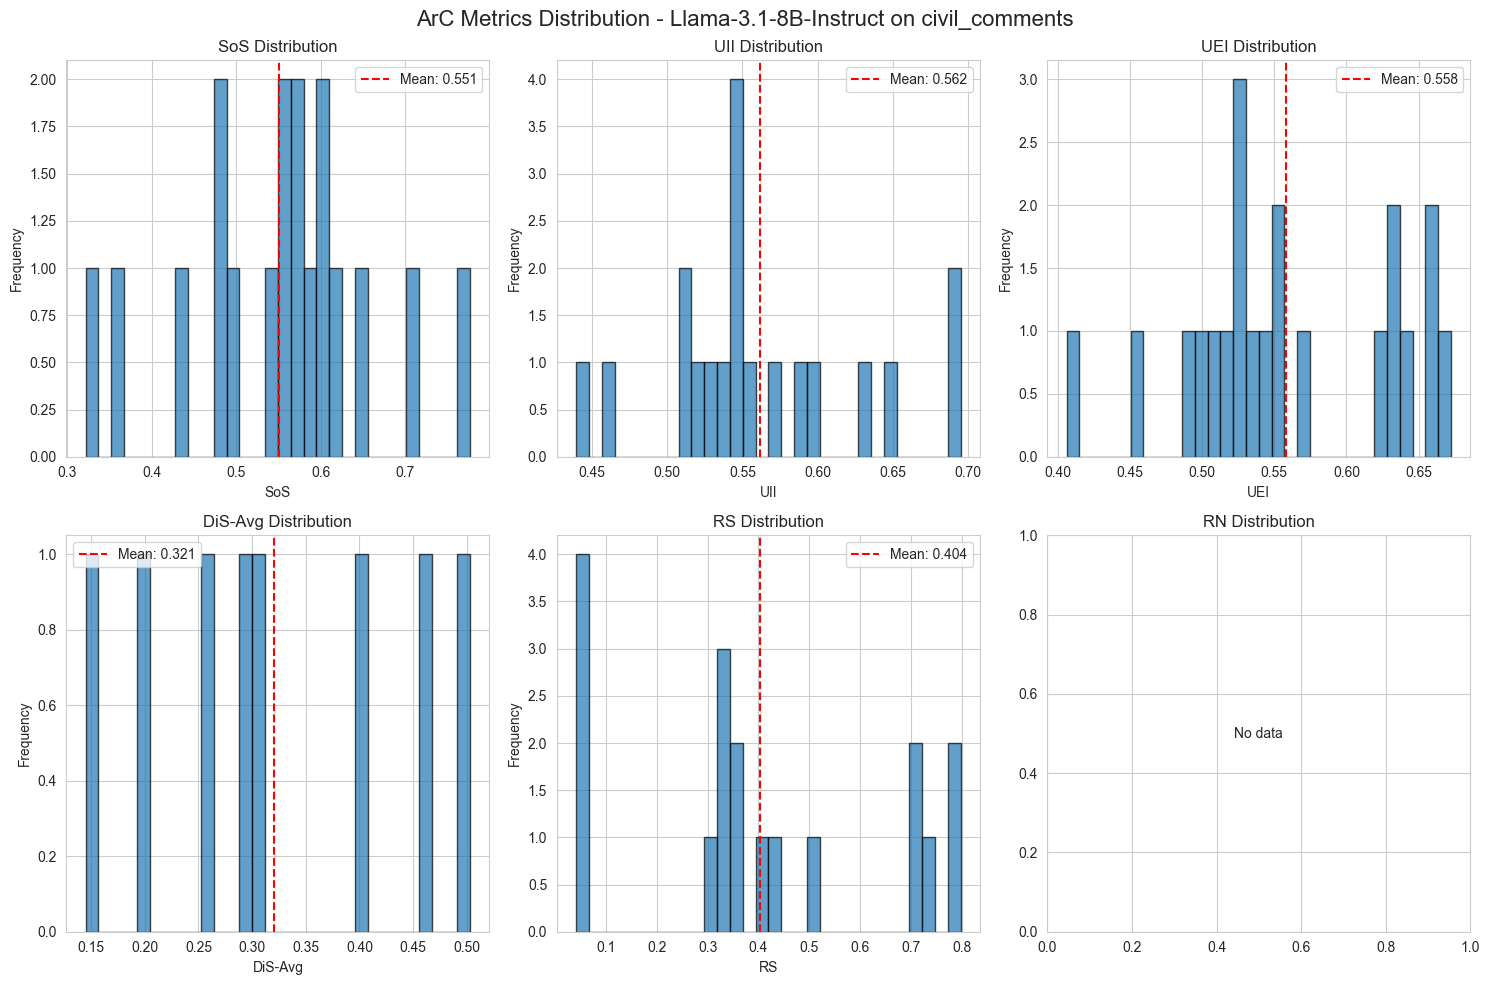

In [7]:
if results:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'ArC Metrics Distribution - {model_name} on {data_name}', fontsize=16)
    
    # Plot distributions
    metrics_to_plot = [
        (sos_values, 'SoS', axes[0, 0]),
        (uii_values, 'UII', axes[0, 1]),
        (uei_values, 'UEI', axes[0, 2]),
        (dis_avg_values, 'DiS-Avg', axes[1, 0]),
        (rs_values, 'RS', axes[1, 1]),
        (rn_values, 'RN', axes[1, 2]),
    ]
    
    for values, name, ax in metrics_to_plot:
        if values:
            ax.hist(values, bins=30, edgecolor='black', alpha=0.7)
            ax.set_xlabel(name)
            ax.set_ylabel('Frequency')
            ax.set_title(f'{name} Distribution')
            ax.axvline(np.mean(values), color='red', linestyle='--', label=f'Mean: {np.mean(values):.3f}')
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{name} Distribution')
    
    plt.tight_layout()
    plt.show()

## 7. Decision Confidence Analysis

C:\Users\RDR\AppData\Local\Temp\ipykernel_9372\512760890.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([confidence_data['Initial'], confidence_data['Internal'], confidence_data['External']],


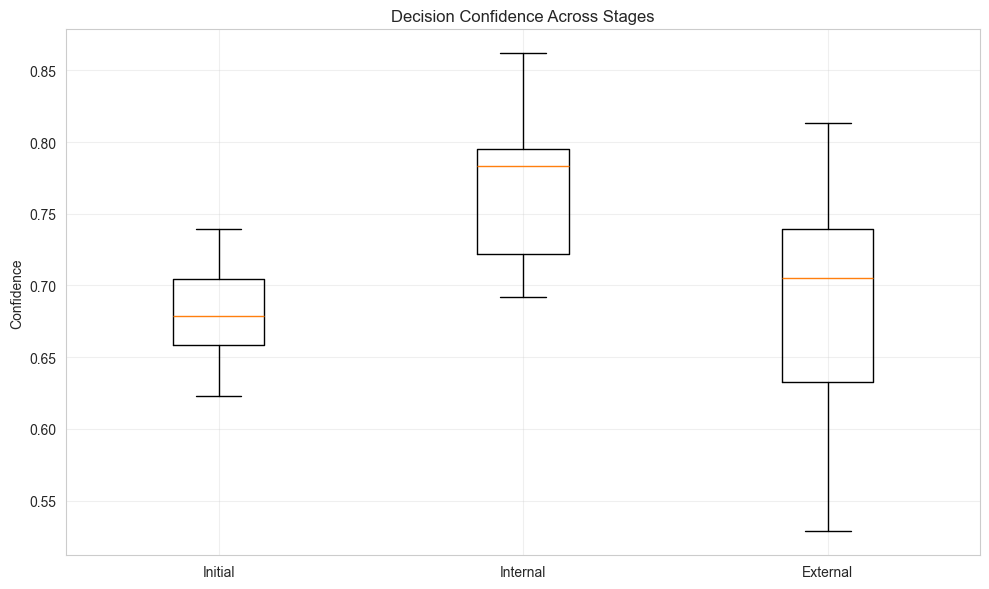


Decision Confidence Statistics:
  Initial: Mean=0.6800, Std=0.0355
  Internal: Mean=0.7681, Std=0.0546
  External: Mean=0.6873, Std=0.0823


In [8]:
if results and initial_conf:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    confidence_data = {
        'Initial': initial_conf,
        'Internal': internal_conf,
        'External': external_conf
    }
    
    positions = [1, 2, 3]
    bp = ax.boxplot([confidence_data['Initial'], confidence_data['Internal'], confidence_data['External']], 
                     positions=positions, labels=['Initial', 'Internal', 'External'])
    
    ax.set_ylabel('Confidence')
    ax.set_title('Decision Confidence Across Stages')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nDecision Confidence Statistics:")
    for stage, values in confidence_data.items():
        if values:
            print(f"  {stage}: Mean={np.mean(values):.4f}, Std={np.std(values):.4f}")

## 8. Computing Metrics for New Data

Here's how to compute ArC metrics for a single sample programmatically.

In [9]:
# Example: Compute metrics for a specific sample
sample_idx = 0
model_name = "meta-llama/Llama-3.1-8B-Instruct"
data_name = "civil_comments"

# Load output tokens and parsed outputs
output_tokens_dict = hp.get_output_tokens(model_name, data_name, config.explicit_prompting)
parsed_output_dict = hp.get_parsed_outputs(model_name, data_name, config.explicit_prompting)

# Compute metrics for the sample
sample_result = service.compute_sample(
    sample_idx, model_name, data_name,
    output_tokens_dict, parsed_output_dict
)

print(f"\nComputed metrics for sample {sample_idx}:")
print(f"  Number of initial reasons: {len(sample_result.get('initial_reasons', []))}")
print(f"  Initial decision confidence: {sample_result.get('initial_decision_confidence', 'N/A')}")
print(f"  SoS scores: {sample_result.get('SoS', {})}")
print(f"  DiS-Avg: {sample_result.get('DiS_avg', 'N/A')}")


Computed metrics for sample 0:
  Number of initial reasons: 2
  Initial decision confidence: 0.7029434442520142
  SoS scores: {'reason_0': 0.5775197267532349, 'reason_1': 0.5535004079341889}
  DiS-Avg: 0.2911096782255296


## 9. Comparing Multiple Models

Load and compare results from different models.


Model Comparison (SoS Metric):
                     Model  SoS_Mean  SoS_Std  Samples
     Llama-3.1-8B-Instruct  0.550502 0.108534        8
     Llama-3.2-3B-Instruct  0.596477 0.122616        8
Ministral-8B-Instruct-2410  0.581023 0.104355        8


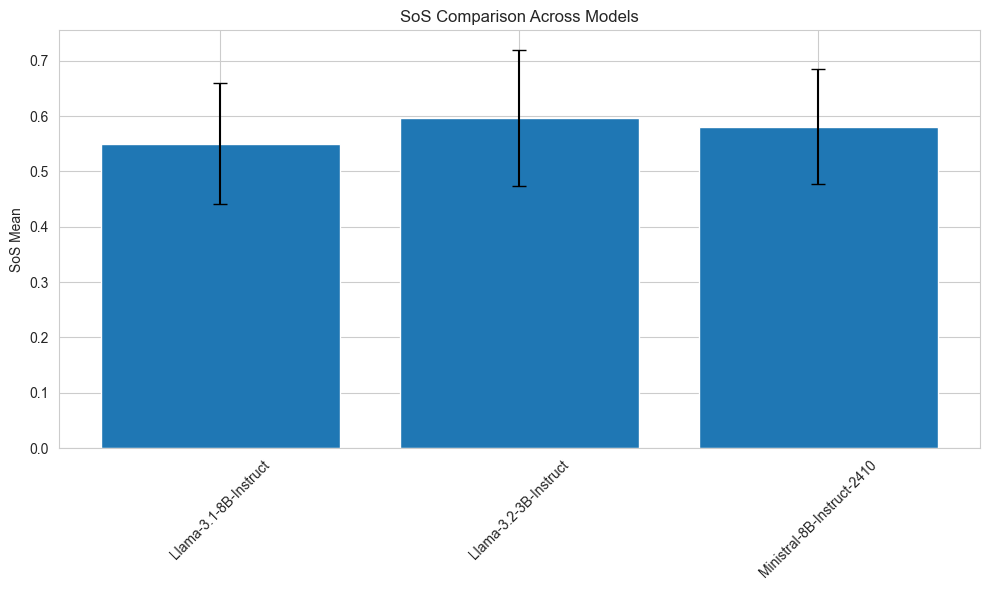

In [10]:
# Compare multiple models
models_to_compare = ["Llama-3.1-8B-Instruct", "Llama-3.2-3B-Instruct", "Ministral-8B-Instruct-2410"]
data_name = "civil_comments"

comparison_data = []

for model in models_to_compare:
    results_path = Path("arc_results") / model / data_name
    if results_path.exists():
        results = []
        for pkl_file in sorted(results_path.glob("*.pkl")):
            with open(pkl_file, 'rb') as f:
                results.append(pickle.load(f))
        
        # Collect SoS values
        sos_vals = []
        for r in results:
            if 'SoS' in r:
                sos_vals.extend([v for v in r['SoS'].values() if not pd.isna(v)])
        
        if sos_vals:
            comparison_data.append({
                'Model': model,
                'SoS_Mean': np.mean(sos_vals),
                'SoS_Std': np.std(sos_vals),
                'Samples': len(results)
            })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\nModel Comparison (SoS Metric):")
    print(comparison_df.to_string(index=False))
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(comparison_df['Model'], comparison_df['SoS_Mean'], yerr=comparison_df['SoS_Std'], capsize=5)
    ax.set_ylabel('SoS Mean')
    ax.set_title('SoS Comparison Across Models')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

## Summary

This notebook demonstrated:

1. How to configure and initialize the ArC framework
2. Loading and examining pre-computed results
3. Analyzing individual sample metrics
4. Computing aggregate statistics across samples
5. Visualizing metric distributions
6. Programmatically computing metrics for new samples
7. Comparing results across different models

For more information, see the [ArC paper](https://arxiv.org/pdf/2506.19113) and the project README.